<a href="https://colab.research.google.com/github/shaghayegh5ghasemi/supervised_fuzzy_clustering/blob/main/Supervised_Fuzzy_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as f
import numpy as np

In [2]:
# load data
trainset = datasets.CIFAR10(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
trainloader = DataLoader(dataset=trainset, batch_size=1, shuffle=True)
testset = datasets.CIFAR10(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
testloader = DataLoader(dataset=testset, batch_size=1, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset/
Files already downloaded and verified


In [3]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# dataset keeps our windows, class_label_matrix keeps the label of windows
dataset = []
class_label_matrix = []

# centroid and cov of each cluster
centroids = []
covariances = []
inverted_covariances = []

# initialize the centroids and the parameters
number_of_dimensions = 27
number_of_classes = len(classes)

gamma = 1
sigma = 0.5
threshold = 0.06
beta = 1

In [4]:
# plot the image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy() # convert from tensor
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [5]:
def make_window(dataset, class_label_matrix, img, label, number_of_classes):
  windows = img.unfold(1, 3, 2).unfold(2, 3, 2) # unflod(dimension, size, step)
  for i in range(15):
    for j in range(15):
      dataset.append(windows[:, i, j].reshape(27))
      temp = [0]*number_of_classes
      temp[label] = 1
      class_label_matrix.append(temp)

In [6]:
def make_dataset(dataset, class_label_matrix):
  c = [0]*10
  for i, (inputs, labels) in enumerate(trainloader):
    if all(x == 10for x in c):
      break
    if c[labels[0]] == 10:
      continue
    else:
      c[labels[0]] += 1
      make_window(dataset, class_label_matrix, inputs[0], labels[0], 10)

In [7]:
make_dataset(dataset, class_label_matrix)
dataset = torch.stack(dataset)
class_label_matrix = torch.tensor(class_label_matrix, dtype=torch.float32)

In [8]:
def calculate_mahanalobis_distance(icm, m, x):
  # D^2 = (x-m)^T * C^-1 * (x-m), mahanalobis distance formula
  s = x.reshape((27, 1))-m.reshape((27, 1))
  return torch.transpose(s, 0, 1)@icm@s

In [9]:
def initialize_centroids(dataset, centroids, inverted_covariances, covariances, number_of_dimensions, gamma, sigma, threshold):
  number_of_centroids = 0
  for data in dataset:
    if number_of_centroids == 0:
      number_of_centroids += 1
      centroids.append(data)
      covariances.append(sigma*torch.eye(number_of_dimensions))
      inverted_covariances.append(torch.eye(number_of_dimensions)/sigma)
    else:
      distances = []
      for i in range(len(centroids)):
        distances.append(calculate_mahanalobis_distance(inverted_covariances[i], centroids[i], data))
      distances = -1*gamma*torch.tensor(distances)
      RM = torch.exp(distances)
      if max(RM) < threshold:
        number_of_centroids += 1
        centroids.append(data)
        covariances.append(sigma*torch.eye(number_of_dimensions))
        inverted_covariances.append(torch.eye(number_of_dimensions)/sigma)

In [10]:
initialize_centroids(dataset, centroids, inverted_covariances, covariances, number_of_dimensions, gamma, sigma, threshold)
q = torch.zeros((len(centroids), number_of_classes), dtype=torch.float32) # matrix that contains the probibilities number of clusters x number of classes

In [11]:
print(len(centroids))

57


In [12]:
from torch.nn.functional import normalize
def calculate_membership_matrix(dataset ,centroids, inverted_covariances, gamma):
  RM = torch.zeros((len(dataset), len(centroids)), dtype=torch.float32) # matrix that contains the memberships number of samples x number of clusters
  for i in range(len(centroids)):
    xc = dataset-centroids[i]
    temp = ((xc@inverted_covariances[0])*xc)@torch.ones((27, 1))
    mem = torch.exp(-1*gamma*temp)
    RM[:, i] = mem[:, 0]
  #normalize the matirx
  miu_ik = normalize(RM, p=1.0, dim = 1)
  return miu_ik

In [13]:
def update_centroids(dataset, centroids, inverted_covariances, q, gamma, beta):
  updated_centroid = []
  miu_ik = calculate_membership_matrix(dataset ,centroids, inverted_covariances, gamma)
  for i in range(len(centroids)):
    temp = class_label_matrix*miu_ik[:, [i]]
    cnt = torch.sum(temp, 0).reshape((1, len(class_label_matrix[0]))) 
    q[i, :] = cnt/torch.sum(cnt)
    temp2 = torch.sum(q[i]*class_label_matrix, 1).reshape([len(dataset), 1])*miu_ik[:, [i]]
    temp3 = torch.transpose(temp2, 0, 1)@dataset
    updated_centroid.append((1-beta)*centroids[i] + beta*(temp3)/torch.sum(temp2))
  return updated_centroid

Ta inja iradi peyda nakardam
---


be ye chizi shak kardam unam khoroji func calculate_mahanalobis_distance bood ke shapesh [[1, 1]] bood va man addade tosho nadade boodam vali hich kodum farghi nadasht

---
mohasebeye miu ro avaz kardam va alan kheili sari tar anjam mishe, addada taghriban ba raveshe ghabl yekie vali khob membership haye koochiktar az ye chizio hazf nemikonam va hmono mizaram >>>>> kheili sari shod

---

dashtam markaz cherto pert misakhtam!


In [14]:
def calculate_inverted_covariance(covariance):
  covariance = np.array(covariance)
  l, mygamma = np.linalg.eig(covariance) # calculate eigenvalues and eigenvectors
  mylambda = np.zeros((l.shape[0], l.shape[0])) # construct a diagnosal matrix with eigenvalues
  # normalize the matirx
  sum_of_rows = l.sum()
  l = l/sum_of_rows
  l = l.astype(np.float32)
  l_sorted = np.sort(l)
  for i in range(l.shape[0]):
    if l[i] < l_sorted[3]:
      mylambda[i][i] = np.float32(0)
    else:
      mylambda[i][i] = np.float32(1/l[i])
  icm = (mygamma)@(mylambda)@(mygamma.T) # invert of the covariance matrix
  icm = np.float32(icm)
  return torch.tensor(icm)

In [15]:
def update_covariances(dataset, centroids, covariances, inverted_covariances, q, classes, gamma, beta):
  miu_ik = calculate_membership_matrix(dataset ,centroids, inverted_covariances, gamma)
  for i in range(len(centroids)):
    temp = class_label_matrix*miu_ik[:, [i]]
    cnt = torch.sum(temp, 0).reshape((1, len(class_label_matrix[0]))) 
    q[i, :] = cnt/torch.sum(cnt)
    temp2 = torch.sum(q[i]*class_label_matrix, 1).reshape([len(dataset), 1])*miu_ik[:, [i]]

    x_clusteri = dataset - centroids[i]
    temp3 = torch.transpose(temp2*x_clusteri, 0, 1)@x_clusteri
    covariances[i] = (1-beta)*covariances[i] + beta*temp3/torch.sum(temp2)
    inverted_covariances[i] = calculate_inverted_covariance(covariances[i])

In [16]:
def calculate_entropy(dataset, centroids, inverted_covariances, classes, q, gamma):
  ent = -1*torch.sum(torch.mean(q*torch.log(q) + 0.00001), axis=0)
  return ent

In [17]:
entropy_curve = []
for i in range(50):
  centroids = update_centroids(dataset, centroids, inverted_covariances, q, gamma, beta)
  update_covariances(dataset, centroids, covariances, inverted_covariances, q, classes, gamma, beta)
  entropy = calculate_entropy(dataset, centroids, inverted_covariances, classes, q, gamma)
  entropy_curve.append(entropy)
  print(entropy)

tensor(0.2260)
tensor(0.2153)
tensor(0.2121)
tensor(0.2094)
tensor(0.2061)
tensor(0.2037)
tensor(0.2019)
tensor(0.2002)
tensor(0.1992)
tensor(0.1980)
tensor(0.1969)
tensor(0.1955)
tensor(0.1946)
tensor(0.1930)
tensor(0.1920)
tensor(0.1909)
tensor(0.1904)
tensor(0.1898)
tensor(0.1895)
tensor(0.1887)
tensor(0.1883)
tensor(0.1878)
tensor(0.1876)
tensor(0.1872)
tensor(0.1872)
tensor(0.1869)
tensor(0.1871)
tensor(0.1869)
tensor(0.1874)
tensor(0.1873)
tensor(0.1878)
tensor(0.1879)
tensor(0.1884)
tensor(0.1885)
tensor(0.1888)
tensor(0.1888)
tensor(0.1890)
tensor(0.1890)
tensor(0.1890)
tensor(0.1891)
tensor(0.1891)
tensor(0.1893)
tensor(0.1892)
tensor(0.1894)
tensor(0.1892)
tensor(0.1894)
tensor(0.1893)
tensor(0.1895)
tensor(0.1893)
tensor(0.1895)


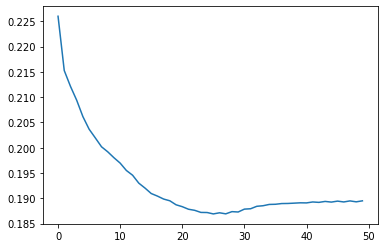

In [18]:
import matplotlib.pyplot as plt
plt.plot(entropy_curve)
plt.show()

In [19]:
def calculate_membership(icm, vi, x, gamma):
  distance = calculate_mahanalobis_distance(icm, vi, x)
  # if torch.exp(-1*gamma*distance) < 0.0001:
  #   return torch.array(0.0001)
  # else:
  return torch.exp(-1*gamma*distance)

p l a n e


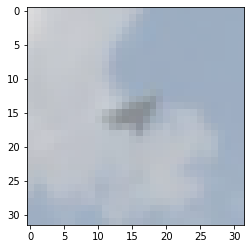

window number 1 belongs to cluster 16
window number 2 belongs to cluster 23
window number 3 belongs to cluster 6
window number 4 belongs to cluster 22
window number 5 belongs to cluster 44
window number 6 belongs to cluster 16
window number 7 belongs to cluster 23
window number 8 belongs to cluster 38
window number 9 belongs to cluster 38
window number 10 belongs to cluster 3
window number 11 belongs to cluster 3
window number 12 belongs to cluster 3
window number 13 belongs to cluster 3
window number 14 belongs to cluster 3
window number 15 belongs to cluster 3
window number 16 belongs to cluster 16
window number 17 belongs to cluster 23
window number 18 belongs to cluster 22
window number 19 belongs to cluster 22
window number 20 belongs to cluster 3
window number 21 belongs to cluster 3
window number 22 belongs to cluster 38
window number 23 belongs to cluster 38
window number 24 belongs to cluster 13
window number 25 belongs to cluster 45
window number 26 belongs to cluster 3
windo

In [20]:
label = torch.tensor(12)
for i, (inputs, labels) in enumerate(testloader):
  if label != torch.tensor(12):
    break
  if labels[0] in [torch.tensor(0), torch.tensor(1), torch.tensor(2)]:
    image = inputs[0]
    label = labels[0]
print(' '.join('%5s' % classes[label]))
imshow(torchvision.utils.make_grid(image))

windows = image.unfold(1, 3, 2).unfold(2, 3, 2) # unflod(dimension, size, step)
test = []
for i in range(15):
  for j in range(15): 
    test.append(windows[:, i, j].reshape(27))

windows_max_membership = []
for w in test:
  memberships = []
  for i in range(len(centroids)):
    memberships.append(calculate_membership(inverted_covariances[i], centroids[i], w, gamma))
  test = torch.tensor(memberships)
  windows_max_membership.append(torch.argmax(test))


for i in range(len(test)):
  print(f'window number {i+1} belongs to cluster {windows_max_membership[i] + 1}')
  


In [21]:
print(centroids)

[tensor([[0.8456, 0.8429, 0.8405, 0.8427, 0.8402, 0.8389, 0.8340, 0.8335, 0.8311,
         0.8654, 0.8627, 0.8602, 0.8626, 0.8602, 0.8585, 0.8524, 0.8517, 0.8490,
         0.8853, 0.8826, 0.8800, 0.8816, 0.8793, 0.8776, 0.8694, 0.8688, 0.8659]]), tensor([[0.6317, 0.6577, 0.6315, 0.5554, 0.6149, 0.6224, 0.5406, 0.5541, 0.5678,
         0.6214, 0.6491, 0.6237, 0.5452, 0.6072, 0.6139, 0.5316, 0.5468, 0.5592,
         0.6139, 0.6427, 0.6171, 0.5325, 0.5962, 0.6041, 0.5157, 0.5328, 0.5464]]), tensor([[0.2639, 0.2677, 0.2722, 0.2667, 0.2712, 0.2737, 0.2700, 0.2737, 0.2777,
         0.2216, 0.2260, 0.2301, 0.2255, 0.2303, 0.2321, 0.2295, 0.2335, 0.2364,
         0.2290, 0.2334, 0.2367, 0.2313, 0.2365, 0.2378, 0.2328, 0.2371, 0.2391]]), tensor([[0.5621, 0.5615, 0.5601, 0.5633, 0.5625, 0.5615, 0.5616, 0.5627, 0.5621,
         0.5621, 0.5613, 0.5601, 0.5631, 0.5621, 0.5612, 0.5611, 0.5621, 0.5615,
         0.5552, 0.5540, 0.5525, 0.5558, 0.5544, 0.5531, 0.5533, 0.5539, 0.5530]]), tensor([[0.4291